In [805]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pept import PointData
from scipy.stats import rv_histogram
from lmfit import Model
import sys
sys.path.append("/home/rayhaan/randomWalk_V3/Scripts/")
from velocityCalculation import Velocity
from tqdm import tqdm
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib widget

In [806]:
def loadTruePath(path: str) -> PointData:
    data = np.loadtxt(path, skiprows = 3)
    points = np.array([data[:, 0], data[:, 5], data[:, 6], data[:, 7]]).T
    pData = PointData(points)
    return pData

In [938]:
trueData = loadTruePath(path = "/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_0.1mm_Varying_Tau_0.08_1.20ms/Placements/RW3_TS_1.20ms_SS_0.10mm.placements")
trackedPath = PointData(np.load("/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_0.1mm_Varying_Tau_0.08_1.20ms/Tracks/RW3_TS_1.20ms_SS_0.10mm.npy"))

In [939]:
Velocitytrue = Velocity(locations = trueData)
Velocitytrack = Velocity(locations = trackedPath)

In [940]:
vels_true = Velocitytrue.fit(method = "two point")
vels_track_2 = Velocitytrack.fit(method = "two point")
vels_track_6 = Velocitytrack.fit(method = "six point")
vels_track_s = Velocitytrack.fit(method = "spline", porder = 1)

In [941]:
xmax = 0.25
xmin = -xmax

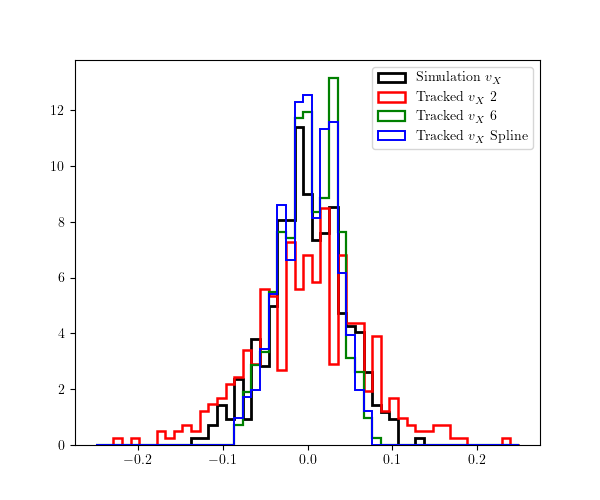

In [942]:
plt.close("all")
fig, ax = plt.subplots(1, 1, figsize = (6, 5))

bins_edges = np.linspace(xmin, xmax, 50)

counts_true, _, _ = ax.hist(vels_true['vx']/1000, bins = bins_edges, histtype = "step", density = True, lw = 2, color = 'k', label = r"Simulation $v_{X}$", zorder = 0)
counts_track_2, _, _ = ax.hist(vels_track_2['vx']/1000, bins = bins_edges, histtype = "step", density = True, lw = 1.8, color = 'r', label = r"Tracked $v_{X}$ 2", zorder = 1)
counts_track_6, _, _ = ax.hist(vels_track_6['vx']/1000, bins = bins_edges, histtype = "step", density = True, lw = 1.6, color = 'g', label = r"Tracked $v_{X}$ 6", zorder = 2)
counts_track_s, _, _ = ax.hist(vels_track_s['vx']/1000, bins = bins_edges, histtype = "step", density = True, lw = 1.4, color = 'b', label = r"Tracked $v_{X}$ Spline", zorder = 3)

ax.legend(loc = "upper right")



In [923]:
# everything works now, *phew*
# Now just look at approx edge cases.
# approx edge cases would be 
# 1) Lambda = 2.0 mm, Tau = 0.1 ms, Doing this now ....
# 2) Lambda = 2.0 mm, Tau = 1.0 ms
# 3) Lambda = 0.1 mm, Tau = 0.1 ms
# 4) Lambda = 0.1 mm, Tau = 1.0 ms

In [943]:
weights_true = 1/counts_true
weights_true[weights_true == np.inf] = 0

weights_track_2 = 1/counts_track_2
weights_track_2[weights_track_2 == np.inf] = 0

weights_track_6 = 1/counts_track_6
weights_track_6[weights_track_6 == np.inf] = 0

weights_track_s = 1/counts_track_s
weights_track_s[weights_track_s == np.inf] = 0


/tmp/ipykernel_1218662/3728410330.py:1: RuntimeWarning: divide by zero encountered in true_divide
  weights_true = 1/counts_true
/tmp/ipykernel_1218662/3728410330.py:4: RuntimeWarning: divide by zero encountered in true_divide
  weights_track_2 = 1/counts_track_2
/tmp/ipykernel_1218662/3728410330.py:7: RuntimeWarning: divide by zero encountered in true_divide
  weights_track_6 = 1/counts_track_6
/tmp/ipykernel_1218662/3728410330.py:10: RuntimeWarning: divide by zero encountered in true_divide
  weights_track_s = 1/counts_track_s


In [944]:
binCentres = np.array([(bins_edges[i] + bins_edges[i+1])/2 for i in range(len(bins_edges)-1)])

In [945]:
# Compute the average and std of the data to make fitting easer (we don't have to guess anything)
mean_true = np.average(binCentres, weights = counts_true)
std_true = np.sqrt(np.average((binCentres - mean_true)**2, weights = counts_true))

mean_track_2 = np.average(binCentres, weights = counts_track_2)
std_track_2 = np.sqrt(np.average((binCentres - mean_track_2)**2, weights = counts_track_2))

mean_track_6 = np.average(binCentres, weights = counts_track_6)
std_track_6 = np.sqrt(np.average((binCentres - mean_track_6)**2, weights = counts_track_6))

mean_track_s = np.average(binCentres, weights = counts_track_s)
std_track_s = np.sqrt(np.average((binCentres - mean_track_s)**2, weights = counts_track_s))



In [946]:
def Gaussian(x, mu, sig):
    y = (1/(np.sqrt(2*np.pi)*sig)) * np.exp(-((x - mu)**2)/(2*sig**2))
    return y

In [947]:
gModel = Model(Gaussian)

In [948]:
outTrue = gModel.fit(x = binCentres, data = counts_true, mu = mean_true, sig = std_true, nan_policy = "omit", weights = weights_true)
print(outTrue.fit_report())

[[Model]]
    Model(Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 49
    # variables        = 2
    chi-square         = 3.84606975
    reduced chi-square = 0.08183127
    Akaike info crit   = -120.693657
    Bayesian info crit = -116.910017
[[Variables]]
    mu:   0.00514765 +/- 0.00166980 (32.44%) (init = -0.0005435588)
    sig:  0.04581896 +/- 0.00111492 (2.43%) (init = 0.04462521)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu, sig) = 0.123


In [949]:
outTrack2 = gModel.fit(x = binCentres, data = counts_track_2, mu = mean_track_2, sig = std_track_2, nan_policy = "omit", weights = weights_track_2)
print(outTrack2.fit_report())

[[Model]]
    Model(Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 49
    # variables        = 2
    chi-square         = 8.46003610
    reduced chi-square = 0.18000077
    Akaike info crit   = -82.0668760
    Bayesian info crit = -78.2832354
[[Variables]]
    mu:  -0.00312156 +/- 0.00279629 (89.58%) (init = -0.0003038436)
    sig:  0.06580926 +/- 0.00185201 (2.81%) (init = 0.06717593)


In [950]:
outTrack6 = gModel.fit(x = binCentres, data = counts_track_6, mu = mean_track_6, sig = std_track_6, nan_policy = "omit", weights = weights_track_6)
print(outTrack6.fit_report())

[[Model]]
    Model(Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 49
    # variables        = 2
    chi-square         = 1.37108137
    reduced chi-square = 0.02917194
    Akaike info crit   = -171.234807
    Bayesian info crit = -167.451166
[[Variables]]
    mu:  -0.00394074 +/- 9.1893e-04 (23.32%) (init = 0.001194624)
    sig:  0.03193106 +/- 5.0263e-04 (1.57%) (init = 0.033277)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu, sig) = -0.370


In [951]:
outTracks = gModel.fit(x = binCentres, data = counts_track_s, mu = mean_track_s, sig = std_track_s, nan_policy = "omit", weights = weights_track_s)
print(outTracks.fit_report())

[[Model]]
    Model(Gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 49
    # variables        = 2
    chi-square         = 0.74267947
    reduced chi-square = 0.01580169
    Akaike info crit   = -201.276241
    Bayesian info crit = -197.492600
[[Variables]]
    mu:  -3.2072e-04 +/- 7.9269e-04 (247.16%) (init = 0.0008460671)
    sig:  0.03481313 +/- 6.0545e-04 (1.74%) (init = 0.03247931)


In [952]:
xnew = np.linspace(xmin, xmax, 1000)
yTrue = Gaussian(x = xnew, mu = outTrue.params['mu'].value, sig = outTrue.params['sig'].value)
yTrack_2 = Gaussian(x = xnew, mu = outTrack2.params['mu'].value, sig = outTrack2.params['sig'].value)
yTrack_6 = Gaussian(x = xnew, mu = outTrack6.params['mu'].value, sig = outTrack6.params['sig'].value)
yTrack_S = Gaussian(x = xnew, mu = outTracks.params['mu'].value, sig = outTracks.params['sig'].value)

In [953]:
Lambda = 0.10
Tau = 1.20

In [954]:
with open("/home/rayhaan/randomWalk_V3/Data/VelocityAlgorithmInvestigation/Gaussian_Fit_True_Lambda_{}mm.csv".format(Lambda), "a") as fileTrue:
    # fileTrue.write("# The fit parameters to the true data\n")
    # fileTrue.write("# tau (ms), mu (m/s), umu (m/s), std (m/s), ustd (m/s), reduced chi 2\n")
    fileTrue.write("{:.2f}, {}, {}, {}, {}, {}\n".format(Tau, outTrue.params['mu'].value, outTrue.params['mu'].stderr, outTrue.params['sig'].value, outTrue.params['sig'].stderr, outTrue.redchi))

with open("/home/rayhaan/randomWalk_V3/Data/VelocityAlgorithmInvestigation/Gaussian_Fit_Track_2point_Lambda_{}mm.csv".format(Lambda), "a") as fileTrue:
    # fileTrue.write("# The fit parameters to the track data using the 2 point method\n")
    # fileTrue.write("# tau (ms), mu (m/s), umu (m/s), std (m/s), ustd (m/s), reduced chi 2\n")
    fileTrue.write("{:.2f}, {}, {}, {}, {}, {}\n".format(Tau, outTrack2.params['mu'].value, outTrack2.params['mu'].stderr, outTrack2.params['sig'].value, outTrack2.params['sig'].stderr, outTrack2.redchi))

with open("/home/rayhaan/randomWalk_V3/Data/VelocityAlgorithmInvestigation/Gaussian_Fit_Track_6point_Lambda_{}mm.csv".format(Lambda), "a") as fileTrue:
    # fileTrue.write("# The fit parameters to the track data using the 6 point method\n")
    # fileTrue.write("# tau (ms), mu (m/s), umu (m/s), std (m/s), ustd (m/s), reduced chi 2\n")
    fileTrue.write("{:.2f}, {}, {}, {}, {}, {}\n".format(Tau, outTrack6.params['mu'].value, outTrack6.params['mu'].stderr, outTrack6.params['sig'].value, outTrack6.params['sig'].stderr, outTrack6.redchi))

with open("/home/rayhaan/randomWalk_V3/Data/VelocityAlgorithmInvestigation/Gaussian_Fit_Track_Spline_Lambda_{}mm.csv".format(Lambda), "a") as fileTrue:
    # fileTrue.write("# The fit parameters to the track data using the Spline method\n")
    # fileTrue.write("# tau (ms), mu (m/s), umu (m/s), std (m/s), ustd (m/s), reduced chi 2\n")
    fileTrue.write("{:.2f}, {}, {}, {}, {}, {}\n".format(Tau, outTracks.params['mu'].value, outTracks.params['mu'].stderr, outTracks.params['sig'].value, outTracks.params['sig'].stderr, outTracks.redchi))

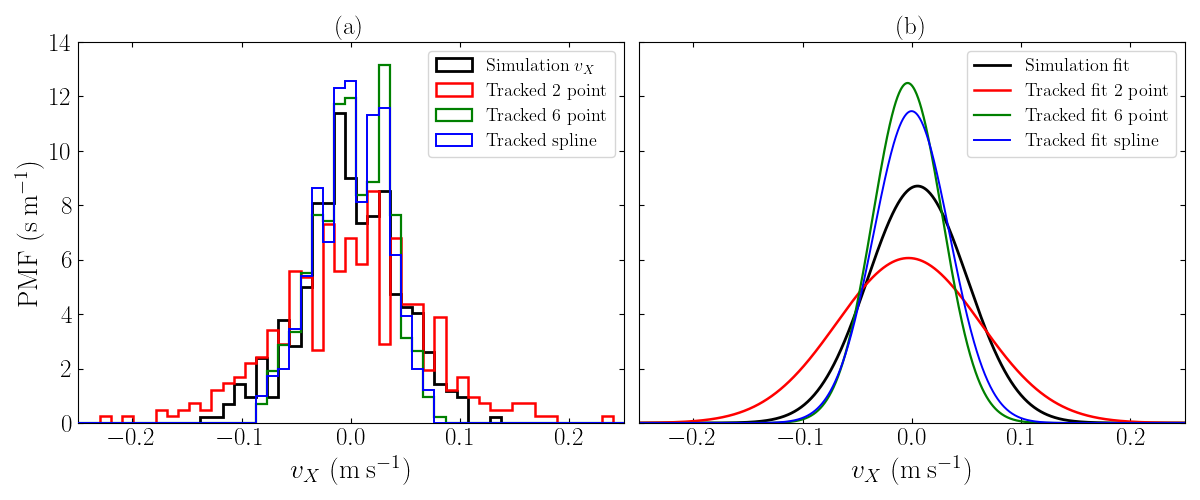

In [956]:
plt.close("all")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5), sharey = "row")
s = 20

bins_edges = np.linspace(xmin, xmax, 50)

counts_true, _, _ = ax1.hist(vels_true['vx']/1000, bins = bins_edges, histtype = "step", density = True, lw = 2, color = 'k', label = r"Simulation $v_{X}$", zorder = 0)
counts_track_2, _, _ = ax1.hist(vels_track_2['vx']/1000, bins = bins_edges, histtype = "step", density = True, lw = 1.8, color = 'r', label = r"Tracked 2 point", zorder = 1)
counts_track_6, _, _ = ax1.hist(vels_track_6['vx']/1000, bins = bins_edges, histtype = "step", density = True, lw = 1.6, color = 'g', label = r"Tracked 6 point", zorder = 2)
counts_track_s, _, _ = ax1.hist(vels_track_s['vx']/1000, bins = bins_edges, histtype = "step", density = True, lw = 1.4, color = 'b', label = r"Tracked spline", zorder = 3)

ax2.plot(xnew, yTrue, color = 'k', lw = 2, label = "Simulation fit")
ax2.plot(xnew, yTrack_2, color = 'r', lw = 1.8, label = r"Tracked fit 2 point")
ax2.plot(xnew, yTrack_6, color = 'g', lw = 1.6, label = r"Tracked fit 6 point")
ax2.plot(xnew, yTrack_S, color = 'b', lw = 1.4, label = r"Tracked fit spline")

ax1.set_ylim(0, 14.0)
ax1.set_xlim(xmin, xmax)
ax2.set_xlim(xmin, xmax)

ax1.get_xaxis().set_tick_params(direction = "in", which = "both", top = True)
ax1.get_yaxis().set_tick_params(direction = "in", which = "both", right = True)
ax2.get_xaxis().set_tick_params(direction = "in", which = "both", top = True)
ax2.get_yaxis().set_tick_params(direction = "in", which = "both", right = True)

ax1.tick_params(axis="x", labelsize = s - 2) 
ax1.tick_params(axis="y", labelsize = s - 2)
ax2.tick_params(axis="x", labelsize = s - 2) 
ax2.tick_params(axis="y", labelsize = s - 2)

ax1.set_ylabel(r"PMF (s$\:$m$^{-1}$)", fontsize = s)
ax1.set_xlabel(r"$v_{X}$ (m$\:$s$^{-1}$)", fontsize = s)
ax2.set_xlabel(r"$v_{X}$ (m$\:$s$^{-1}$)", fontsize = s)

ax1.legend(loc = "upper right", fontsize = s - 7)
ax2.legend(loc = "upper right", fontsize = s - 7)

ax1.set_title("(a)", fontsize = s - 2)
ax2.set_title("(b)", fontsize = s - 2)

fig.tight_layout()
fig.savefig("/home/rayhaan/randomWalk_V3/Plots/Lambda_0.1mm_Hist+Fits/velHist+Fit_Lambda_{:.2f}_Tau_{:.2f}.png".format(Lambda, Tau), dpi = 300)


